**Código-exemplo para disciplina de Deep Learning: Convolução**

Código para aproveitamento dos treinos já aprendidos pela VGG16. Para outras redes, acesse: https://keras.io/api/applications/

Abril/2023

Professor: Sérgio Canuto



In [1]:
import tensorflow as tf
from tensorflow import keras
import warnings
warnings.filterwarnings("ignore")

In [2]:
tf.__version__

'2.10.0'

In [3]:
keras.__version__

'2.10.0'

**Compatibilidade com a versão 1 do tensorflow: Habilita recursos do tensorboard**




In [4]:
#tf.compat.v1.disable_v2_behavior()

In [5]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import plot_model
model = VGG16()
print(model.summary())
#plot_model(model, to_file='vgg.png')

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [6]:
import numpy as np
from sklearn.utils import resample

#obtém os dados
fashion_mnist=keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

from sklearn.utils import resample
X_train_full, y_train_full = resample(X_train_full,
                                      y_train_full,
                                      n_samples=10000,
                                      random_state=0)

In [7]:
X_valid, X_train = X_train_full[:9000]/255., X_train_full[9000:]/255.
y_valid, y_train = y_train_full[:9000], y_train_full[9000:]

In [8]:
# e transforma um canal em preto-branco em três canais em preto-e-branco:
# (necessário para entrada da VGG16)
X_train=np.dstack([X_train]*3)
X_valid=np.dstack([X_valid]*3)

X_train = X_train.reshape(-1, 28, 28, 3)
X_valid = X_valid.reshape(-1, 28, 28, 3)
print("Dimensão dos documentos de treino:")
print(X_train.shape)

Dimensão dos documentos de treino:
(1000, 28, 28, 3)


In [9]:
# "redimensiona o tamanho das imagens para" 48x48 como requisito do VGG16 pré-treinado.
# para mais informações, acesse: https://keras.io/api/applications/vgg/#vgg16-function

from tensorflow.keras.utils import img_to_array, array_to_img
X_train = np.asarray(
    [img_to_array(array_to_img(im, scale=False).resize((48,48)))
    for im in X_train]
    )
X_valid = np.asarray(
    [img_to_array(array_to_img(im, scale=False).resize((48,48)))
    for im in X_valid]
    )

X_train.shape, X_valid.shape

((1000, 48, 48, 3), (9000, 48, 48, 3))

In [10]:
from keras.applications import VGG16
#carrega o modelo VGG16
vgg_model = VGG16(
                weights='imagenet',
                include_top=False,
                input_shape=(48, 48, 3)
                )

# Seta as camadas iniciais para apenas leitura (não treináveis!)
for layer in vgg_model.layers[:15]:
    layer.trainable = False

print(vgg_model.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [11]:
#Obêm o modelo VGG e adiciona só duas camadas densas no topo do modelo para o treinamento.
model=vgg_model.output
topo_model = keras.layers.Flatten()(model)
topo_model = keras.layers.Dense(40, activation='relu')(topo_model)
topo_model = keras.layers.Dense(10, activation='softmax')(topo_model) # Softmax for multiclass
modelo_final = tf.keras.Model(inputs=vgg_model.input, outputs=topo_model)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

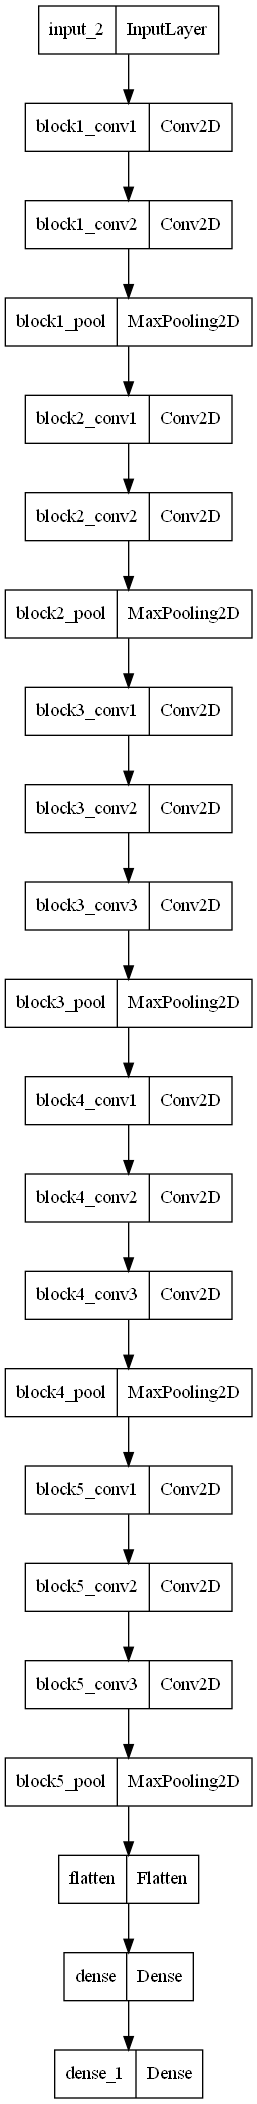

In [12]:
print(modelo_final.summary())
plot_model(modelo_final, to_file='vgg.png')

In [13]:
modelo_final.compile(
                loss="sparse_categorical_crossentropy",
                optimizer="sgd",
                metrics=["accuracy"],
                )
history=modelo_final.fit(
                X_train,
                y_train,
                epochs=30,
                batch_size=16,
                validation_data=(X_valid,y_valid)
                )

Epoch 1/30
63/63 [==============================] - 19s 231ms/step - loss: 2.2416 - accuracy: 0.1690 - val_loss: 2.1567 - val_accuracy: 0.2116
Epoch 2/30
63/63 [==============================] - 16s 265ms/step - loss: 2.0921 - accuracy: 0.2290 - val_loss: 2.1346 - val_accuracy: 0.2422
Epoch 3/30
63/63 [==============================] - 14s 225ms/step - loss: 1.9803 - accuracy: 0.2780 - val_loss: 2.0532 - val_accuracy: 0.2650
Epoch 4/30
63/63 [==============================] - 14s 227ms/step - loss: 1.9115 - accuracy: 0.3100 - val_loss: 2.0232 - val_accuracy: 0.2650
Epoch 5/30
63/63 [==============================] - 14s 226ms/step - loss: 1.8480 - accuracy: 0.3330 - val_loss: 2.0300 - val_accuracy: 0.2578
Epoch 6/30
63/63 [==============================] - 13s 211ms/step - loss: 1.8075 - accuracy: 0.3490 - val_loss: 2.0040 - val_accuracy: 0.2738
Epoch 7/30
63/63 [==============================] - 13s 207ms/step - loss: 1.7722 - accuracy: 0.3600 - val_loss: 1.9443 - val_accuracy: 0.2843

In [14]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

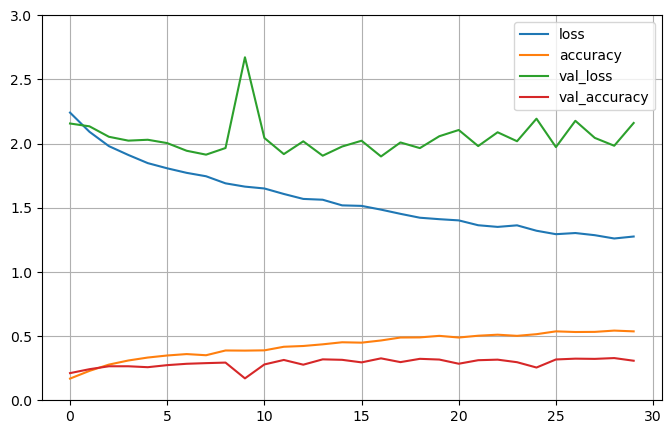

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,3)
plt.show()

In [16]:
X_test=np.dstack([X_test]*3)
X_test = X_test.reshape(-1, 28, 28, 3)
X_test = np.asarray(
    [img_to_array(array_to_img(im, scale=False).resize((48,48)))
    for im in X_test]
    )
X_test.shape

(10000, 48, 48, 3)

In [17]:
modelo_final.evaluate(X_test/255.,y_test)

313/313 [==============================] - 9s 25ms/step - loss: 3.2307 - accuracy: 0.2973


[3.230710029602051, 0.2973000109195709]